In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

# Import TDA pipeline requirements
import gudhi as gd
import json

from scipy import ndimage, interpolate

In [9]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [10]:
maximgsize = 1250
mintransnum = 5
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
ksrc = '../kde/'
csrc = '../data/'
dst = '../gd_trans/'

sample = 'D2'

ksrc += sample + os.sep
dst = dst + sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = sorted([foo.split('/')[-2] for foo in glob(ksrc + '*/')])
print(len(transcriptomes), 'transcriptomes')

97 transcriptomes


In [11]:
wallshape = (np.max(metacell['x1']), np.max(metacell['x1']))
wallshape

(17152, 17152)

In [14]:
tidx = 31
print('Analyze',transcriptomes[tidx])
sdst = dst + transcriptomes[tidx] + os.sep
if not os.path.isdir(sdst):
    os.mkdir(sdst)

kdefiles = glob(ksrc + transcriptomes[tidx] + os.sep + '*.npy')
ratios = transcell.iloc[tidx, :-1].values.astype(float) / metatrans.loc[tidx, 'cyto_number']
#transnum = transcell.iloc[tidx, :-1].values.astype(float)
#ratios = transnum[transnum > mintransnum]/np.sum(transnum[transnum > mintransnum])

metakde = np.zeros((len(kdefiles), 4), dtype=int)
rawkdemax = np.zeros(len(metakde))
for i in range(len(kdefiles)):
    foo = (os.path.splitext(os.path.split(kdefiles[i])[1])[0]).split('_')
    for j in range(metakde.shape[1]):
        metakde[i,j] = int(foo[j][1:])
    rawkdemax[i] = float(foo[-1][1:])
metakde = pd.DataFrame(metakde, columns=['ndimage_cellID', 'pad', 'stepsize', 'bandwidth'])
metakde['rawkdemax'] = rawkdemax
metakde['transnum'] = transcell.iloc[tidx, metakde['ndimage_cellID'].values].values.astype(int)
metakde['ratio_all'] = ratios[metakde['ndimage_cellID'].values]
metakde['ratio_select'] = metakde['transnum']/np.sum(metakde['transnum'])
metakde['kdemax_all'] = metakde['rawkdemax']*metakde['ratio_all']
metakde['kdemax_select'] = metakde['rawkdemax']*metakde['ratio_select']
metakde = metakde[metakde['ndimage_cellID'] != 0]

print(metakde.shape)
metakde.head(10)
#metakde.sort_values(by='kdemax_all', ascending=False).head(10)

Analyze GLYMA_06G090100
(135, 10)


,ndimage_cellID,pad,stepsize,bandwidth,rawkdemax,transnum,ratio_all,ratio_select,kdemax_all,kdemax_select
0,315,6,5,15,0.000282,7,0.001495,0.005790,4.221247e-07,1.634730e-06
1,946,6,5,15,0.000174,6,0.001282,0.004963,2.234386e-07,8.652931e-07
2,391,6,5,15,0.000138,6,0.001282,0.004963,1.763902e-07,6.830927e-07
3,2177,6,5,15,0.000145,8,0.001709,0.006617,2.485670e-07,9.626061e-07
4,2800,6,5,15,0.000216,12,0.002563,0.009926,5.539788e-07,2.145351e-06
5,533,6,5,15,0.000218,7,0.001495,0.005790,3.265934e-07,1.264773e-06
6,2269,6,5,15,0.000116,8,0.001709,0.006617,1.984362e-07,7.684683e-07
7,2335,6,5,15,0.000172,6,0.001282,0.004963,2.202687e-07,8.530174e-07
8,289,6,5,15,0.000135,6,0.001282,0.004963,1.726555e-07,6.686293e-07
9,2520,6,5,15,0.000126,17,0.003631,0.014061,4.582749e-07,1.774725e-06


In [13]:
metakde[metakde['ndimage_cellID'] == 2499]

,ndimage_cellID,pad,stepsize,bandwidth,rawkdemax,transnum,ratio_all,ratio_select,kdemax_all,kdemax_select
111,2499,6,5,15,0.000197,10,0.002136,0.008271,4.213233e-07,0.000002


In [15]:
selection = 'all'
vmax = np.max(metakde['kdemax_' + selection])
bins = np.linspace(0, vmax, 256)

idx = 111

jsname = '_'.join(np.asarray(os.path.splitext(os.path.split(kdefiles[idx])[1])[0].split('_'))[[0,3]])
cidx = metakde.loc[idx,'ndimage_cellID']
kde = np.load(kdefiles[idx], allow_pickle=True)*metakde.loc[idx, 'ratio_' + selection]

In [16]:
PP = metakde.loc[idx, 'pad']
stepsize = metakde.loc[idx, 'stepsize']
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wallshape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wallshape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cy = ss[0].stop - ss[0].start
cx = ss[1].stop - ss[1].start
xaxis = np.arange(0, cx, stepsize); yaxis = np.arange(0, cy, stepsize)
xaxis += ss[1].start; yaxis += ss[0].start

In [17]:
cp = cartesian_product(np.arange(yaxis[0],yaxis[-1]), np.arange(xaxis[0],xaxis[-1]))
interp = interpolate.RegularGridInterpolator((yaxis, xaxis), kde, method='linear', bounds_error=True, fill_value=None)
img = interp(cp)
img = np.digitize(img, bins, right=True).astype(np.uint8).reshape(yaxis[-1]-yaxis[0],xaxis[-1]-xaxis[0])
img = np.pad(img, 5)

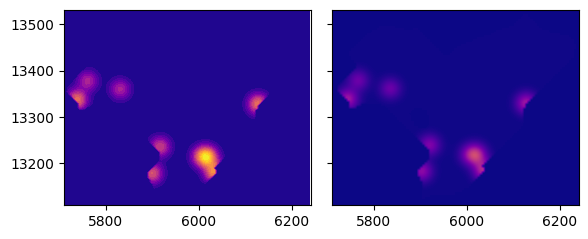

In [18]:
fs = 15
fig, ax = plt.subplots(1,2,figsize=(6,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].contourf(xaxis, yaxis, kde, 16, cmap='plasma')
ax[1].imshow(img, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=255)

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    
fig.tight_layout();

# Match cells

In [19]:
if max(img.shape) > maximgsize:
    zoom = maximgsize/max(img.shape)
    print(kdefiles[idx], '\nResized', img.shape, 'by a factor of ', zoom)
    img = ndimage.zoom(img, zoom = zoom, order=1, mode='reflect')
    print('Now', img.shape, '\n----')

In [21]:
cc = gd.CubicalComplex(top_dimensional_cells = img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_' + selection + '_sublevel.json'
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

[(1, (0.0, 136.0)),
 (1, (1.0, 87.0)),
 (1, (1.0, 86.0)),
 (1, (2.0, 74.0)),
 (1, (16.0, 65.0)),
 (1, (7.0, 51.0)),
 (1, (40.0, 52.0)),
 (1, (98.0, 104.0)),
 (0, (0.0, inf))]

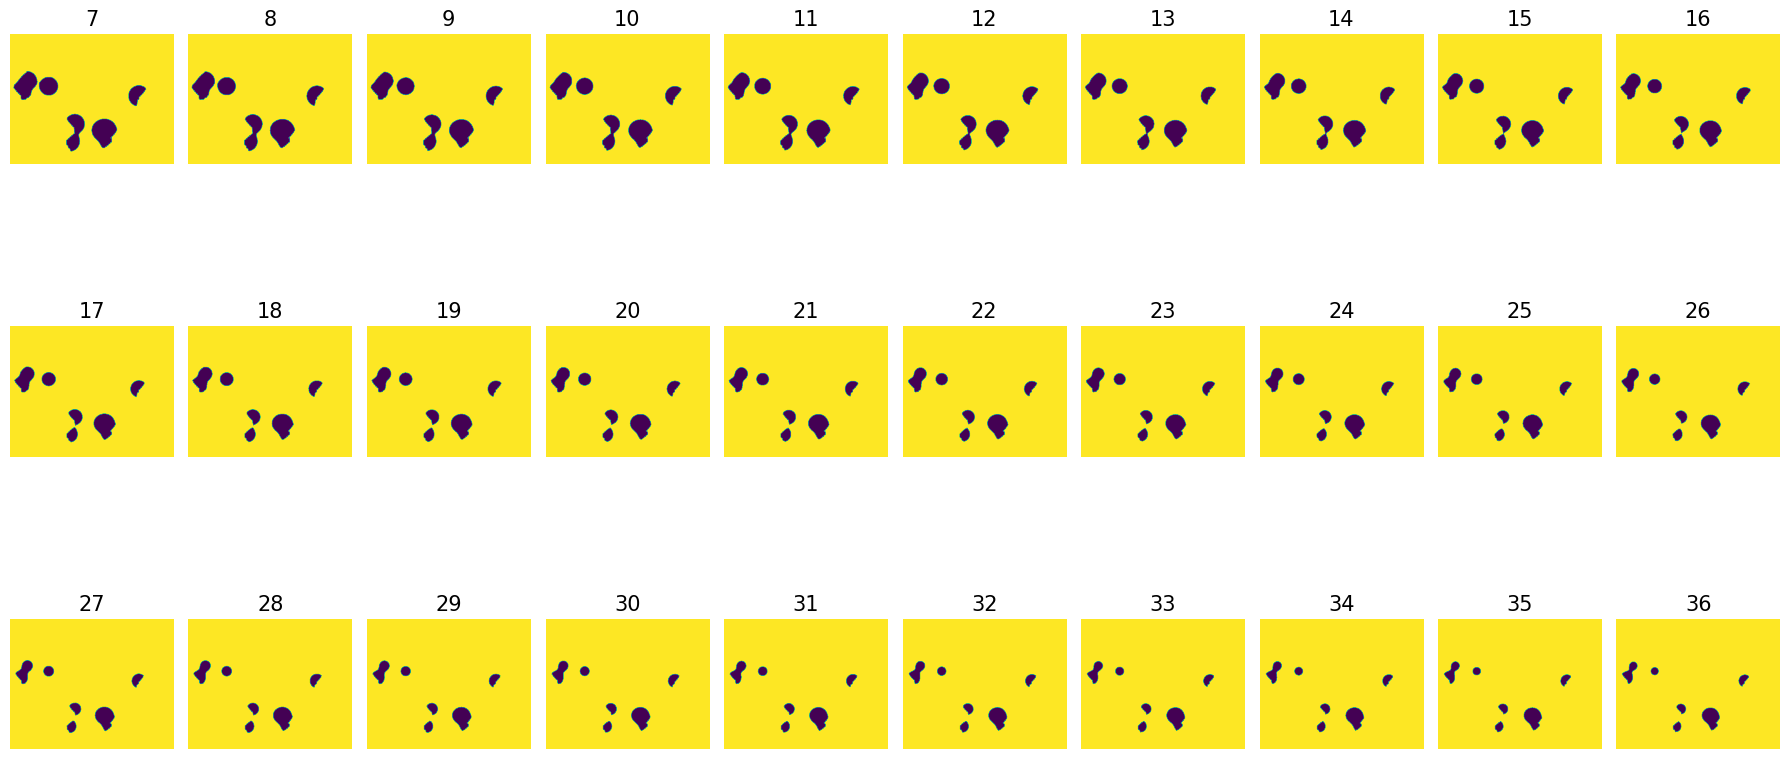

In [22]:
fig, ax = plt.subplots(3,10, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 7

for i in range(len(ax)):
    ax[i].imshow(img <= k + i, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(k + i, fontsize=15)
    ax[i].axis('off');

fig.tight_layout();

In [23]:
maxv = img.max()
cc = gd.CubicalComplex(top_dimensional_cells = maxv-img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_' + selection + '_superlevel.json'
print(filename)
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

../gd_trans/D2/GLYMA_06G090100/GLYMA_06G090100_c2499_b15_all_superlevel.json


[(0, (0.0, inf)),
 (0, (49.0, 135.0)),
 (0, (50.0, 135.0)),
 (0, (62.0, 134.0)),
 (0, (71.0, 120.0)),
 (0, (85.0, 129.0)),
 (0, (84.0, 96.0)),
 (0, (32.0, 37.0))]

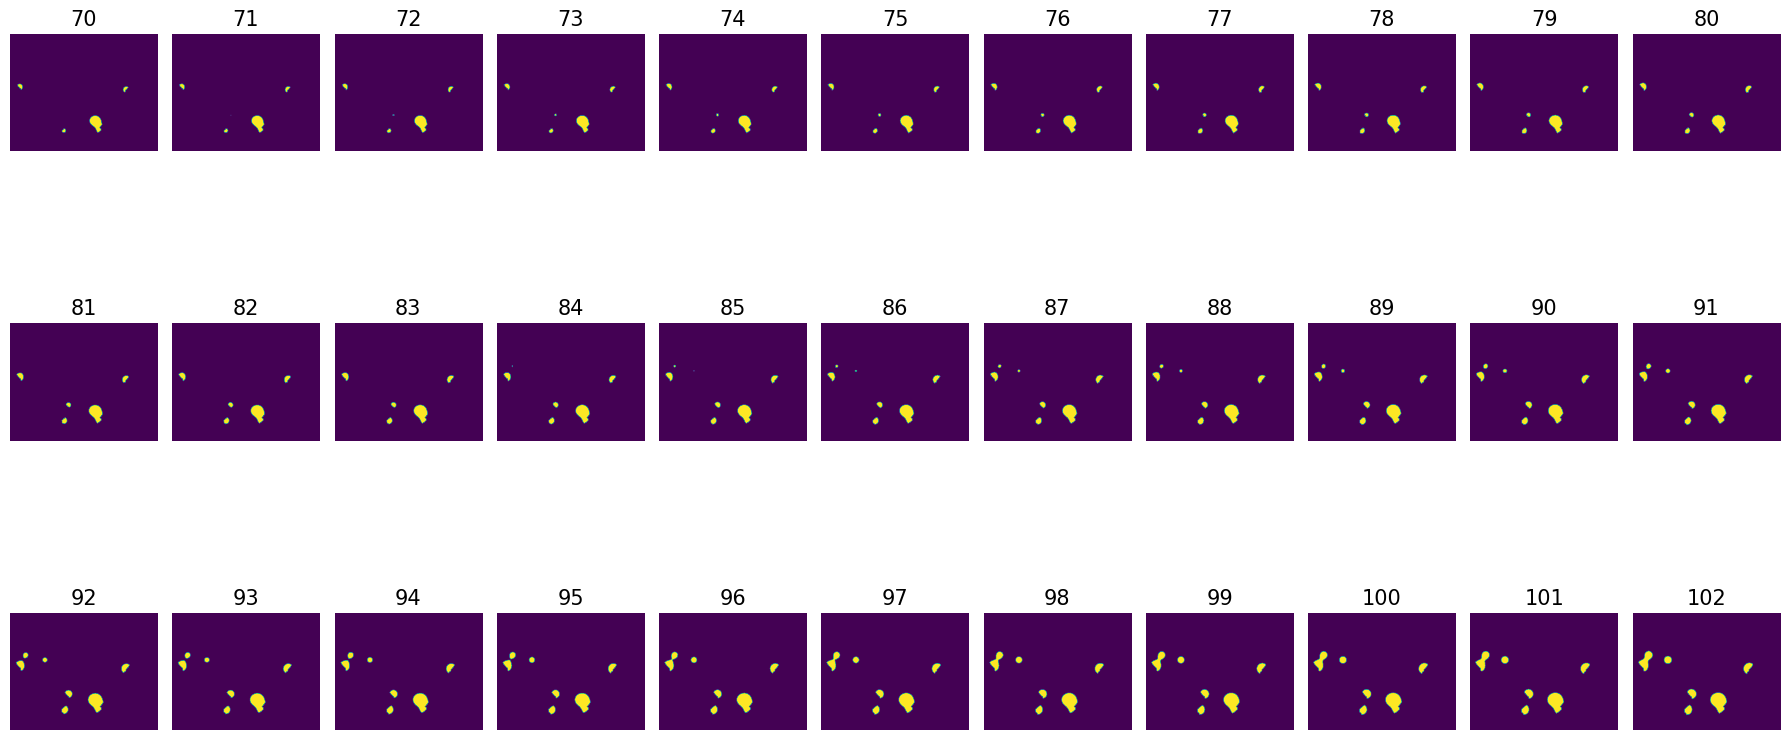

In [24]:
fig, ax = plt.subplots(3,11, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 70
bar = maxv - img 
for i in range(len(ax)):
    #j = len(ax) - 1 - i
    j = i
    ax[j].imshow(bar <= k + i, vmin=0, vmax=1, origin='lower');
    ax[j].set_title(k + i, fontsize=15)
    ax[j].axis('off');

fig.tight_layout();